<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/2.model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Stretch tasks:
    - CV
    - best_params_
    - Short list of models
    - sklearn.metrics module

# Imports

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# Grid search
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [4]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


files = [
    'path_manager.py',
    'sklearn_utils.py',
    'sklearn_transformers.py',
    'model.py'
]

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'
url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [5]:
import importlib
import path_manager
import sklearn_transformers
import sklearn_utils
import model

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils,
        sklearn_transformers,
        model
    ]
)

from path_manager import PathManager

from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import nan_statistics
from sklearn_utils import visualize_datasets_distributions
from sklearn_utils import print_model_cv_scores

from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
from model import Model

# Setup paths

In [6]:
# %%pycodestyle
from dataclasses import dataclass
from dataclasses import field
import os
import pickle


@dataclass
class PathManager:
    competition_path: str
    preprocessing_trial: int
    models_trial: int

    def __post_init__(self):
        self.data_root_path = os.path.join(self.competition_path, 'Data')
        self.models_root_path = os.path.join(self.competition_path, 'Models')

        self.data_trial_path = os.path.join(
            self.data_root_path,
            f'preproc_trial_{self.preprocessing_trial}'
        )
        self.models_trial_path = os.path.join(
            self.models_root_path,
            f'trial_{self.models_trial}'
        )

    @property
    def train_path(self):
        return os.path.join(self.data_root_path, 'train.csv')

    @property
    def test_path(self):
        return os.path.join(self.data_root_path, 'test.csv')

    def _create_path(self, path):
        if not os.path.isdir(path):
            os.mkdir(path)
        else:
            print(f'{path} already exists')

    def save_to_csv(self, array_, path_, file_name_):
        df = pd.DataFrame(array_)
        df.to_csv(os.path.join(path_, file_name_))

    def setup_paths(self):
        # precondition
        assert os.path.isdir(self.data_root_path), print(self.data_root_path)
        assert os.path.isdir(self.models_root_path), \
            print(self.models_root_path)

        self._create_path(self.data_trial_path)
        self._create_path(self.models_trial_path)

    def save_models(self, sklearn_models_dict_):
        '''
        For each model in the dictionary, create a folder.
        Save pickle file there. If model (or folder) already exists -
        overrides all files
        '''
        for model_name, sklearn_model in sklearn_models_dict_.items():
            folder_path = os.path.join(
                self.models_trial_path, model_name
            )
            self._create_path(folder_path)
            model_filename = model_name + '.sav'
            pickle.dump(
                sklearn_model,
                open(
                    os.path.join(folder_path, model_filename),
                    'w+b'
                ),
            )

    def load_models(self, models_subfolders_=[]):
        '''
        1. Goes to self.models_trial_path
        2. If models_names=[] - downloads all
           models from their subfolders.
        3. models_names must contain names of subfolders on
           google drive!
        '''

        # precondition
        assert os.path.isdir(self.models_trial_path), \
            print(self.models_trial_path)

        available_models_subfolders = os.listdir(self.models_trial_path)
        if models_subfolders_:
            models_to_download = models_subfolders_
        else:
            # Download everything
            models_to_download = available_models_subfolders

        res = {}
        for model_subfolder in models_to_download:
            # file name coincides with folder name
            file_name = f'{model_subfolder}.sav'
            full_path = os.path.join(
                self.models_trial_path,
                model_subfolder,
                file_name
            )

            loaded_model = pickle.load(
                open(full_path, 'rb')
            )
            res[model_subfolder] = loaded_model
        return res


pep8(_ih)

In [7]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
path_manager = PathManager(
    competition_path=COMPETITION_PATH, 
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
path_manager.setup_paths()

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_1 already exists


# Download the data

In [9]:
kaggle_test_path = os.path.join(
    path_manager.data_trial_path,
    'test_processed.csv'
)
df_test = pd.read_csv(
    kaggle_test_path, index_col=[0]
)
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-1.032819,-0.285964,-0.26814,-0.383325,-0.807152,-0.633614,-0.182156,-0.619713,-0.217343,-0.244523,...,-0.606797,-0.556056,-0.652386,2011.0,0.0,0.0,1.0,0.0,0.341412,0.693147
1,-0.334236,-0.285964,-0.26814,-0.383325,0.014161,-0.633614,-0.182156,-1.176974,-0.790338,-0.811816,...,-0.606797,-0.556056,-0.652386,2011.0,0.0,0.0,0.0,1.0,2.161000,0.693147


In [10]:
df_test_sample = pd.read_csv(
    os.path.join(path_manager.data_trial_path, 'test_sample_processed.csv'), 
    index_col=[0]
)
df_test_sample.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-1.032819,-1.653875,0.688913,-1.382555,-0.807152,-0.633614,-2.019553,-0.062452,-0.217343,-0.244523,...,-0.606797,-0.556056,-0.652386,2008.0,0.0,0.0,1.0,0.0,1.134031,14.842280
1,0.015056,0.397991,-0.268140,-1.382555,-0.807152,-0.159426,-0.182156,-0.062452,-0.217343,-0.244523,...,0.655776,0.253599,0.511872,2007.0,0.0,0.0,0.0,1.0,1.769000,15.312391


In [11]:
df_trainval = pd.read_csv(
    os.path.join(path_manager.data_trial_path, 'trainval_sample_processed.csv'), 
    index_col=[0]
)
df_trainval.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-0.334236,-0.285964,-1.225193,-0.383325,0.014161,-0.633614,-0.182156,-0.062452,-0.217343,-0.244523,...,0.655776,0.253599,1.094000,2009.0,0.0,0.0,0.0,1.0,2.069,15.278005
1,-0.683527,-0.285964,-1.225193,0.615905,1.656785,0.788952,-0.182156,-0.619713,-0.790338,-0.811816,...,-0.606797,-0.556056,-0.652386,2007.0,1.0,0.0,1.0,0.0,5.663,15.255171


In [12]:
X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

In [13]:
X_test_sample = df_test_sample.values[:, :-1]  # test subsample from training data
Y_test_sample = df_test_sample.values[:, -1]

# Select and train models (+ ensemble methods)

## Define models

In [14]:
RFModel = Model(
    RandomForestRegressor(),
    'RF',
    [
        {'n_estimators': [100, 200, 500]}
    ],

    [
        {
            'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
            'max_depth': [i for i in range(1, 20)]
        }
    ]
)

ElasticNetModel = Model(
    ElasticNet(),
    'Elastic',
    [
        {
            'alpha': [0.1, 0.3, 0.5],
            'l1_ratio': [0.2, 0.4]
        }, 
    ],
    [
        {}
    ]
)

SVRModel = Model(
    SVR(),
    'SVM reg',
    [
        {}
    ],
    [
        {}
    ]
)

In [15]:
all_models = {
    model.name: model for model in [RFModel, SVRModel, ElasticNetModel]
}

## Preliminary look (shortlisting 2-5 models)

## Cross validation result

In [16]:
# def print_model_cv_scores(sklearn_models_dict_, X_, Y_, cv_, scoring_):
#     res = {}
#     for name, model in sklearn_models_dict_.items():
#         scores = cross_val_score(
#             model,
#             X_,
#             Y_,
#             cv=cv_,
#             scoring=scoring_
#         )
#         res[name] = scores
    
#     # Sort the dict
#     sorted_res = {
#         k:v for \
#         k, v in sorted(res.items(), key = lambda item: np.mean(item[1]))
#     }
#     for model_name, scores in sorted_res.items():
#         print(f'Model: {model_name}, mean: {np.mean(scores)}, std: {np.std(scores)}')

#     return sorted_res

In [17]:
_ = print_model_cv_scores(
    sklearn_models_dict_={
        model_name: model.model for model_name, model in all_models.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error'
)

NameError: ignored

## Overfitting behavior

In [ ]:
# %%pycodestyle
from sklearn.model_selection import cross_validate


def plot_cv_results(
    sklearn_models_dict_, X_, Y_, cv_, scoring_, to_put_minus_=False):

    for model_name, model in sklearn_models_dict_.items():
        cv_res = cross_validate(
            model,
            X_,
            Y_,
            cv=cv_,
            scoring=scoring_,
            return_train_score=True
        )
        _, ax = plt.subplots()
        x = np.arange(len(cv_res['test_score']))
        width = 0.5
        if to_put_minus_:
            train_score = -cv_res['train_score']
            test_score = -cv_res['test_score']
        else:
            train_score = cv_res['train_score']
            test_score = cv_res['test_score']

        ax.bar(x - width / 2, test_score, width, label='validation')
        ax.bar(x + width / 2, train_score, width, label='train')

        ax.set_title(f'Results for {model_name}')
        ax.set_xlabel(f'CV fold number')
        ax.set_ylabel(f'Metrics: {scoring_}')

        ax.legend()
        ax.grid()

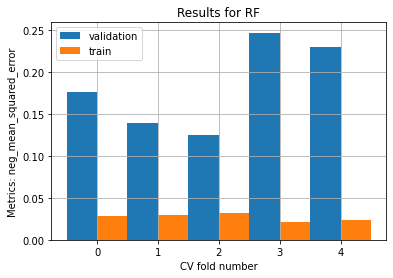

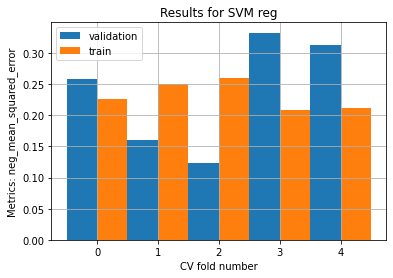

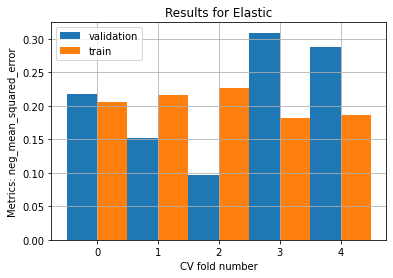

In [ ]:
# %%pycodestyle
plot_cv_results(
    sklearn_models_dict_={
        model_name: model.model for model_name, model in all_models.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

In [ ]:
shortlisted_models = {
    model.name: model for model in [RFModel, ElasticNetModel, SVRModel]
}

# Fine tuning

## Grid search

In [ ]:
def fit_grid_search(models_dict_, X_, Y_, cv_, scoring_):
    res = {
        name: None for name in list(models_dict_.keys())
    }
    for name, model in models_dict_.items():
        print(f'Fitting {name}')
        
        grid_search_estimator = GridSearchCV(
            model.model,
            param_grid=model.grid_search_param_grid,
            cv=cv_,
            scoring=scoring_,
            return_train_score=True,
            refit=True
        )

        grid_search_result = grid_search_estimator.fit(X_, Y_)
        res[name] = grid_search_result
    return res

In [ ]:
grid_search_results = fit_grid_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_ = 5,
    scoring_ = 'neg_mean_squared_error'
)

Fitting RF
Fitting Elastic
Fitting SVM reg


In [ ]:
print(grid_search_results['RF'].best_params_)
print(grid_search_results['Elastic'].best_estimator_)

{'n_estimators': 500}
ElasticNet(alpha=0.5, l1_ratio=0.2)


## Randomized search

In [ ]:
# %%pycodestyle
from sklearn.model_selection import RandomizedSearchCV

def fit_randomized_search(models_dict_, X_, Y_, cv_, n_iter_, scoring_):
    RANDOM_STATE = 42
    res = {}
    for name, model in models_dict_.items():
        print(f'Fitting {name}')

        estimator = RandomizedSearchCV(
            model.model,
            param_distributions=model.random_search_param_grid,
            cv=cv_,
            n_iter=n_iter_,
            scoring=scoring_,
            return_train_score=True,
            refit=True,
            random_state=RANDOM_STATE
        )

        rand_search_res = estimator.fit(X_, Y_)
        res[name] = rand_search_res
    return res

In [ ]:
rand_search_results = fit_randomized_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    n_iter_=10,
    scoring_='neg_mean_squared_error'
)

Fitting RF
Fitting Elastic
Fitting SVM reg


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [ ]:
print(rand_search_results['RF'].best_estimator_)
print(rand_search_results['SVM reg'].best_estimator_)

RandomForestRegressor(max_depth=11, n_estimators=300)
SVR()


# Check final models for overfit

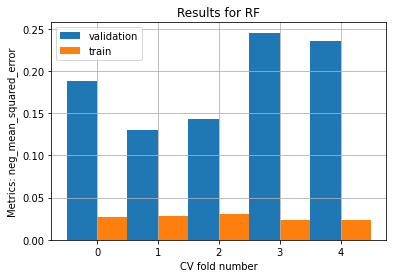

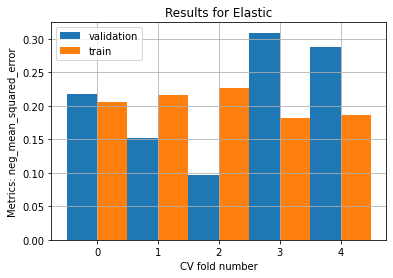

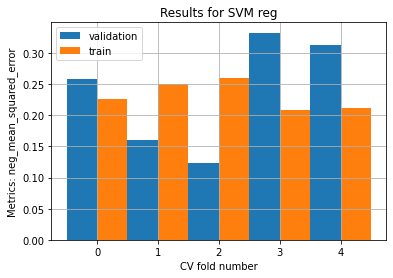

In [ ]:
plot_cv_results(
    sklearn_models_dict_ = {
        name: rand_search_results[name].best_estimator_ \
        for name in rand_search_results.keys()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

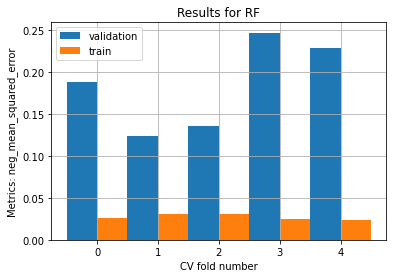

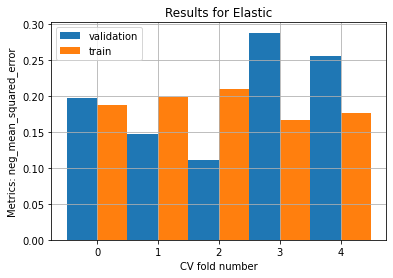

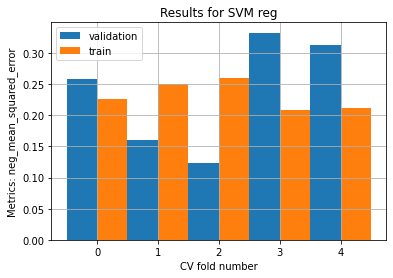

In [ ]:
plot_cv_results(
    sklearn_models_dict_ = {
        name: grid_search_results[name].best_estimator_ \
        for name in grid_search_results.keys()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

# Saving fine tuned candidates (retrained on train+val subset)

In [ ]:
path_manager.save_models(
    {
        model_name: result.best_estimator_
        for model_name, result in rand_search_results.items()
    }
)